In [1]:
cd ..

/Users/mmt/Dropbox/Code/waterbot


In [2]:
import os
import glob
import json

import datetime as dt
import numpy as np
import pandas as pd

from waterbot import util

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

/Users/mmt/anaconda/envs/waterbot/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
MONTHS = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [18]:
reservoirs = json.load(open('reservoirs_all.json'))
    
dfs = []
for reservoir in reservoirs:
    station_id = reservoir['station_id']
    csvpath = 'data/historical_levels/{}.csv'.format(station_id)
    df = pd.read_csv(csvpath, parse_dates=['date'])
    df['station_id'] = station_id
    
    df.loc[ 
          (df['reservoir_storage'] > reservoir['capacity'] * 1.5)
        | (df['reservoir_storage'] < reservoir['capacity'] * 0.01), 
        'reservoir_storage'
    ] = np.nan
    
    df.fillna(
        method='bfill',
        inplace=True
    )
    
    dfs.append(df)
#     print df.date.min()

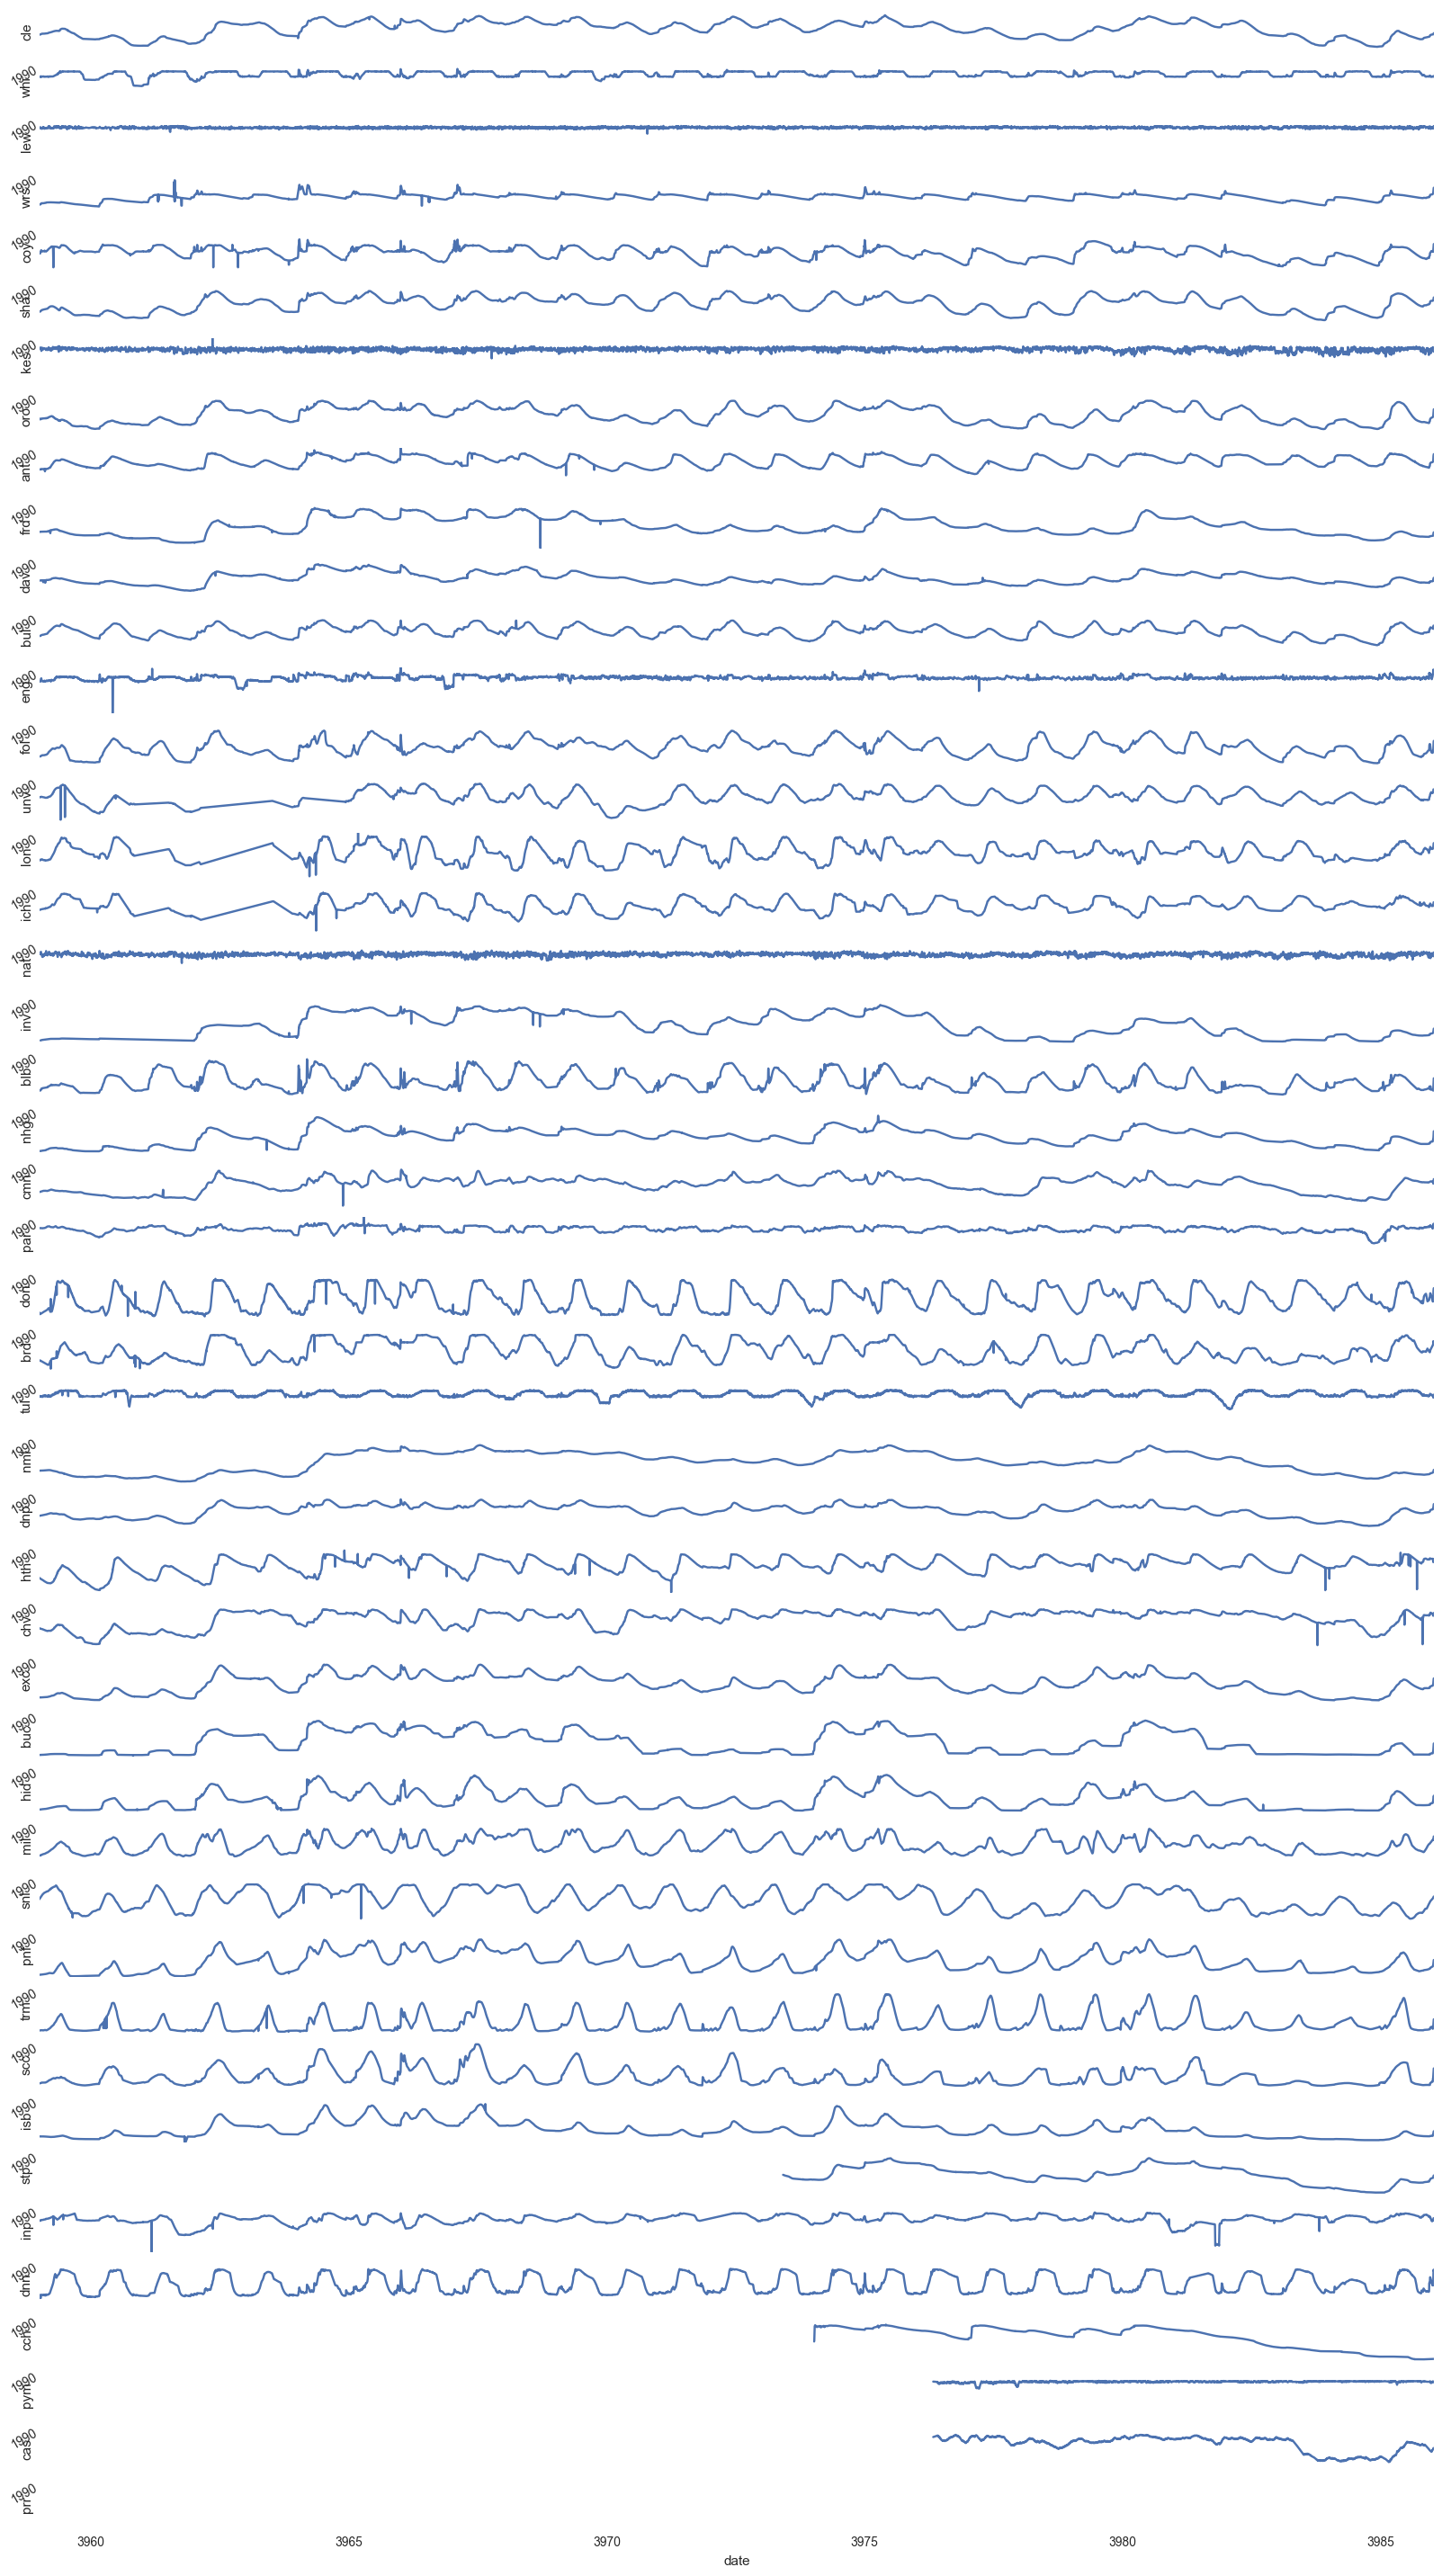

In [19]:
fig = plt.figure(figsize=(20, 40))

xaxis = None

for i, d in enumerate(dfs):
    station_id = d.station_id.iloc[0]
    res = [r for r in reservoirs if r['station_id'] == station_id][0]
#     print res['station_id'], d.date.min(), d.date.max(), res['capacity']
    
    plt.subplot( len(dfs), 1, i+1 )
    d.set_index('date').reservoir_storage.plot()
    sns.despine(left=True, bottom=True)
    plt.ylabel(res['station_id'])
    plt.yticks([])
    if xaxis is None:
        xaxis = list(plt.axis()[:2])
#     else:
#         plt.axis(xaxis + list(plt.axis()[2:]) )
    plt.axis(xaxis + [0, res['capacity'] * 1.2] )

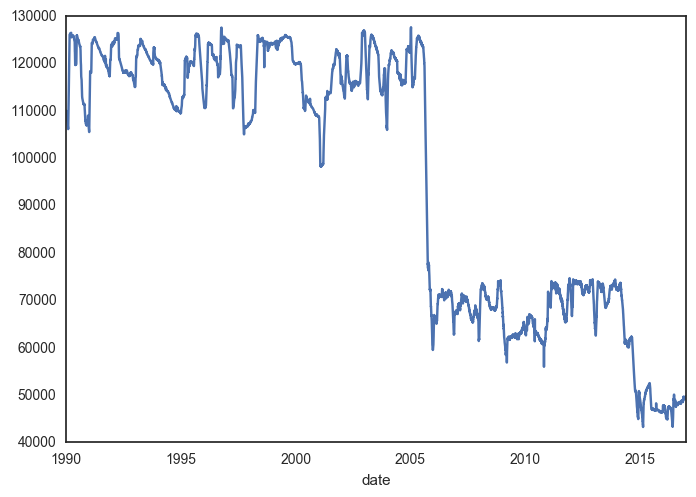

In [20]:
dfs[-1].set_index('date').reservoir_storage.plot()

In [21]:
dfc = pd.concat(dfs)

dfc['day_of_year'] = dfc.date.apply(
    lambda d: d.timetuple().tm_yday
)

dfc.head()

,date,time,reservoir_storage,station_id,day_of_year
0,1990-01-01,0,1258733.0,cle,1
1,1990-01-02,0,1258207.0,cle,2
2,1990-01-03,0,1258102.0,cle,3
3,1990-01-04,0,1257891.0,cle,4
4,1990-01-05,0,1257470.0,cle,5


In [22]:
# (
#     dfc
#     [
#         (dfc.date < dt.date(2010, 1, 1))
#     ]
#     .plot.scatter(x='day_of_year', y='reservoir_storage', figsize=(18,12))
# )

# plt.axis( list(plt.axis()[:2]) + [0, 5e6])

In [23]:
df = (
    dfc
    .groupby('date')
    .agg({
        'reservoir_storage': 'sum',
        'station_id': 'count'
    })
    .reset_index()
)

In [24]:
df['day_of_year'] = df.date.apply(
    lambda d: d.timetuple().tm_yday
)

df.head(20)

,date,reservoir_storage,station_id,day_of_year
0,1990-01-01,11270867.0,38,1
1,1990-01-02,8979852.0,34,2
2,1990-01-03,8970834.0,34,3
3,1990-01-04,8963870.0,34,4
4,1990-01-05,8958284.0,34,5
5,1990-01-06,8964351.0,34,6
6,1990-01-07,9014528.0,34,7
7,1990-01-08,11618454.0,42,8
8,1990-01-09,9114706.0,34,9
9,1990-01-10,9145001.0,34,10


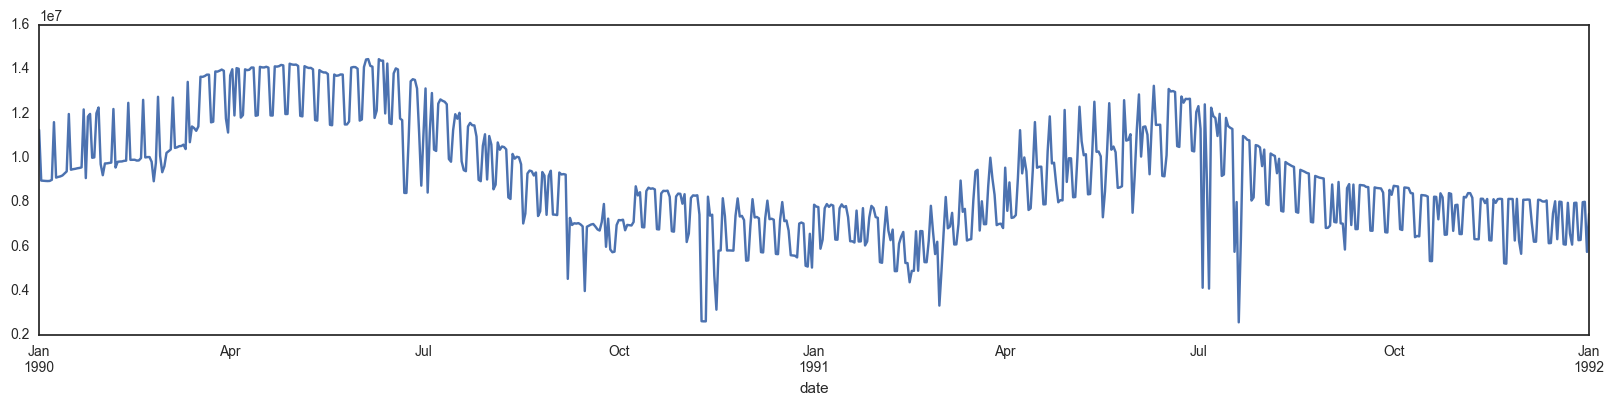

In [25]:
plt.figure(figsize=(20,4))
(
    df
    [ df.date <= dt.date(1992, 1, 1 )]
    .set_index('date')
    .reservoir_storage
    .plot()
)

In [26]:
shades = (
    df
    [
        (df.date < dt.date(2010, 1, 1))
    ]
    .groupby('day_of_year')
    .reservoir_storage
    .agg({
        'lo': lambda x: np.percentile(x, 20),
        'mid': lambda x: np.percentile(x, 40),
        'hi': lambda x: np.percentile(x, 60),
        'median': 'median',
        'mean': 'mean'
    })
)

shades.head()

,lo,hi,median,mid,mean
day_of_year,,,,,
1,9744060.6,15985991.2,14701023.0,13330864.0,14138683.10
2,9829030.4,15701267.2,14883558.5,14170265.0,14428759.35
3,9841233.2,16136757.4,15120407.0,14524048.6,14480550.00
4,9852662.0,16081558.0,15178633.0,14569514.2,14344132.00
5,9866027.2,16185947.8,15193609.5,14616018.6,14508504.20


[1.0, 366.0, 0, 22000000.0]

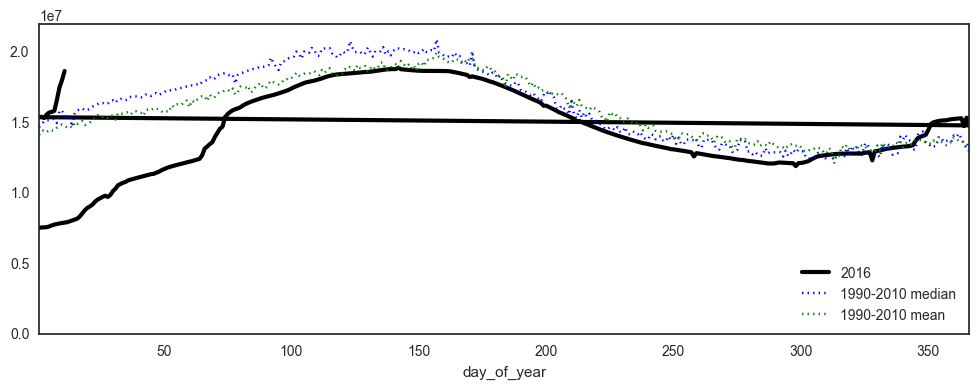

In [27]:
fig = plt.figure(figsize=(12,4))

(
    df
    [
        (df.date >= dt.date(2016, 1, 1)) &
        (df.date <  dt.date(2017, 2, 1))
    ]
    .set_index('day_of_year')
    .reservoir_storage
    .plot(color='black', linewidth=3)
)

shades['median'].plot(linestyle=':', color='blue')
shades['mean'].plot(linestyle=':', color='green')

plt.legend(['2016', '1990-2010 median', '1990-2010 mean'], loc=4)
plt.axis( list(plt.axis()[:2]) + [0, plt.axis()[3]] )

# plt.xticks(range(0, 350, 31), MONTHS)

[0.0, 366.0, 6128229.58, 24947675.58999999]

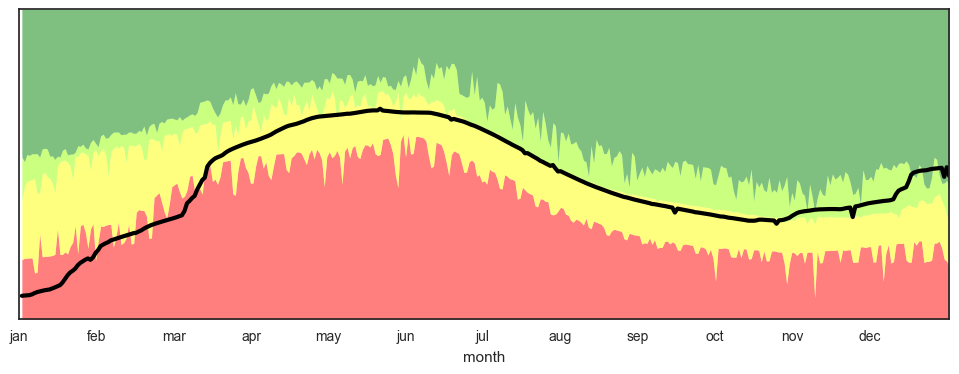

In [16]:
fig, ax = plt.subplots(1, figsize=(12,4))
ax.fill_between(shades.index, df.reservoir_storage.quantile(.01), shades.lo, facecolor='red', alpha=0.5, linewidth=0)
ax.fill_between(shades.index, shades.lo, shades.mid, facecolor='yellow', alpha=0.5, linewidth=0)
ax.fill_between(shades.index, shades.mid, shades.hi, facecolor='#99ff00', alpha=0.5, linewidth=0)
ax.fill_between(shades.index, shades.hi, df.reservoir_storage.quantile(.99), facecolor='green', alpha=0.5, linewidth=0)

(
    df
    [
        (df.date >= dt.date(2016, 1, 1)) 
        & (df.date <  dt.date(2017, 1, 1))
    ]
    .set_index('day_of_year')
    .reservoir_storage
    .plot(color='black', linewidth=3)
)

plt.xticks(np.arange(0, 350, 30.41), MONTHS)
plt.xlabel('month')
plt.yticks([])
plt.axis( list(plt.axis()[:2]) + [ df.reservoir_storage.quantile(.01), df.reservoir_storage.quantile(.99) ] )

([<matplotlib.axis.YTick at 0x11a993d50>,
 <a list of 8 Text yticklabel objects>)

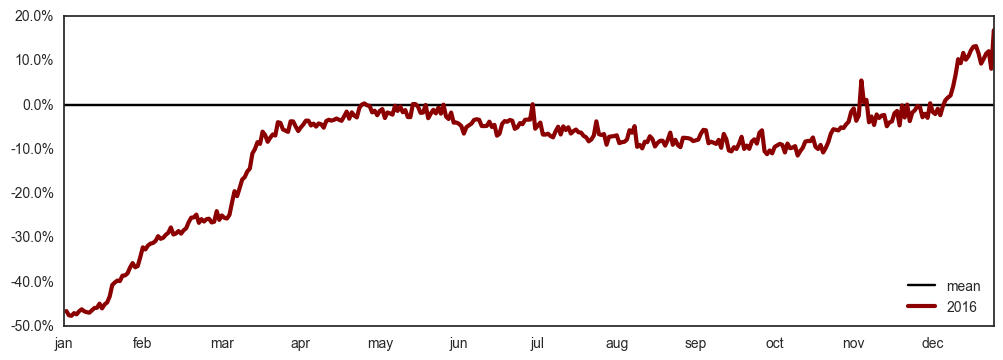

In [17]:
mean_level = shades['mean']

level_2016 = (
    df
    [
        (df.date >= dt.date(2016, 1, 1)) &
        (df.date <  dt.date(2017, 1, 1))
    ]
    .set_index('day_of_year')
    .reservoir_storage
)

fig = plt.figure(figsize=(12, 4))

plt.plot( [0, 365], [0, 0], 'k')
plt.plot( (level_2016 - mean_level) / mean_level * 100, linewidth=3, color='darkred')

plt.axis( [0, 365] + list(plt.axis()[2:]) )
plt.legend(['mean', '2016'], loc=4)
plt.xticks(range(0, 350, 31), MONTHS)

ytic = plt.yticks()[0]    
plt.yticks(ytic, [str(yt)+'%' for yt in ytic])